# Rationale
Let's train a RealPD-only network first, but I hope that there is an increase in metrics if we use both datasets together

In [1]:
import tensorflow as tf
import tf_mapper
from importlib import reload
import pandas as pd
import numpy as np
reload(tf_mapper)
from sklearn.model_selection import train_test_split
from tf_mapper import get_batched_dataset
# tf.enable_eager_execution()
# Helperfunctions to make your feature definition more readable

def read_tfrecord(example):
    features = { \
               'watch_accel':tf.io.FixedLenFeature([1500*3], tf.float32,),\
               'watch_gyro':tf.io.FixedLenFeature([1500*3], tf.float32,),\
               'watch_phone': tf.io.FixedLenFeature([1500*3], tf.float32,),\
               'has_watch_accel': tf.io.FixedLenFeature([1], tf.int64,),\
               'has_gyro':tf.io.FixedLenFeature([1], tf.int64,),\
               'has_phone': tf.io.FixedLenFeature([1], tf.int64,),\
               'on_off': tf.io.FixedLenFeature([1], tf.int64,),\
               'dyskinesia':tf.io.FixedLenFeature([1], tf.int64,),\
               'measurement_id': tf.io.FixedLenFeature([1], tf.int64,),\
               'tremor': tf.io.FixedLenFeature([1], tf.int64,),\
               'subjects': tf.io.FixedLenFeature([1], tf.int64,)
              }

    example = tf.io.parse_single_example(example, features)
    return example
def map_example_to_simple(example):
    data = example['watch_accel']
    data = tf.reshape(data, (1500,3))
    return data, (example['on_off'][0], example['tremor'][0], example['dyskinesia'][0])

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ms994/miniconda3/envs/keras-

In [2]:
def tf_is_in_set(a, b):
    return tf.reduce_sum(tf.cast(tf.equal(b, a), tf.int64)) >= 1

In [3]:

def get_batched_dataset(filenames, batch_size, m_ids, map_func=None, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=3, num_parallel_calls=3)

    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    dataset = dataset.cache()
    dataset = dataset.filter(lambda example: tf_is_in_set(example["measurement_id"][0], tf.constant(m_ids, dtype=tf.int64)))
    dataset = dataset.map(map_func)
    dataset = dataset.filter(lambda x, y: tf.not_equal(y[0], -1))
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x, 0) > 0.05))
    dataset = dataset.filter(lambda x, y: tf.not_equal(y[1], -1))
    dataset = dataset.filter(lambda x, y: tf.not_equal(y[2], -1))
    

    
    dataset = dataset.repeat()
    if is_train:
        dataset = dataset.shuffle(2056)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

In [4]:
labels = pd.concat([pd.read_csv("/home/ms994/beat_pd/data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv"),pd.read_csv("/home/ms994/beat_pd/data/real-pd/data_labels/REAL-PD_Ancillary_Data_IDs_Labels.csv")])

In [5]:
subject_specific = labels.groupby("subject_id").mean().dropna()

In [6]:
filledLabels = labels[labels.subject_id.isin(subject_specific.index)].dropna()
filledLabels = filledLabels.join(subject_specific, on="subject_id", rsuffix="_r")
((filledLabels.on_off - filledLabels.on_off_r)**2).mean(), ((filledLabels.dyskinesia - filledLabels.dyskinesia_r)**2).mean(), ((filledLabels.tremor - filledLabels.tremor_r)**2).mean()

(0.13361368303418647, 0.07335841192333417, 0.30432272522773124)

In [7]:
%%bash
ls /n/scratch2/beat_pd_ms_tmp

all_data.tfr
real_pd_all_data.tfr


In [8]:
all_m_id = labels.measurement_id.unique().tolist()

In [9]:
train_ind, test_ind = train_test_split([i for i in range(len(all_m_id))], random_state=1)
train_ind, valid_ind = train_test_split(train_ind, random_state=1)

In [31]:
import pickle as pkl
allResults = pkl.load(open("/n/scratch2/ms994/realPd.pkl", "rb"))

In [32]:
len(allResults)

63262

In [41]:
(allResults[0][0].std(0) > 0.01).any()

True

In [45]:
allResults = list(filter(lambda x: (x[0].std(0) > 0.01).any(), allResults))
allResults = list(filter(lambda x: (x[1].std(0) > 0.01).any(), allResults))
allResults = list(filter(lambda x: (x[2].std(0) > 0.01).any(), allResults))

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
len(allResults)

41149

In [13]:
from sys import getsizeof

In [14]:
getsizeof(allResults)

569464

In [15]:
allResults = filter(lambda xy: not np.isnan(xy[3].on_off) and not np.isnan(xy[3].tremor) and not np.isnan(xy[3].dyskinesia) ,allResults)
allResults = list(allResults)

In [16]:
len(allResults)

4262

In [17]:
allResults[0][3]

measurement_id     5823b6b4-221b-437c-9afe-9e6cad934bc5
subject_id                                       hbv013
on_off                                                0
dyskinesia                                            0
tremor                                                0
device_id                                          2WH8
smartwatch_data                                    True
gyro_data                                          True
smartphone_data                                    True
Name: 37, dtype: object

In [18]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 256, m_ids=train_ind, map_func=map_example_to_simple)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 256, m_ids=valid_ind, map_func=map_example_to_simple)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 256, m_ids=test_ind, map_func=map_example_to_simple)

In [21]:
iterator = test_data.take(5000).make_one_shot_iterator()

In [20]:
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 5
dropout = 0.5
lin_h=128
inputLayer = tf.keras.layers.Input((1500, 3))
x = inputLayer
x = tf.keras.layers.GaussianNoise(0.005)(x)


for i in range(num_cnn_layers):
    x = tf.keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
    x = tf.keras.layers.BatchNormalization()(x)

for j in range(num_lstm_layers):
    x = tf.keras.layers.CuDNNLSTM(16, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)



x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = tf.keras.layers.Dense(lin_h)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_on_off = tf.keras.layers.ReLU(name="on_off", max_value=1)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_dyskinesia = tf.keras.layers.ReLU(name="dyskinesia", max_value=2)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_tremor = tf.keras.layers.ReLU(name="tremor", max_value=4)(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])

In [21]:
model.compile(tf.keras.optimizers.Adam(lr=0.0005), loss=["mean_squared_error", "mean_squared_error", "mean_squared_error", ], loss_weights=[4,2,1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 1500, 3)      0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 1500, 16)     160         gaussian_noise_2[0][0]           
__________________________________________________________________________________________________
leaky_re_lu_44 (LeakyReLU)      (None, 1500, 16)     0           conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [ ]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm_realpd_no_augment.h5", save_best_only=True, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5)

history = model.fit(train_data, steps_per_epoch=250, epochs=200, validation_data=valid_data, validation_steps=50, callbacks=[modelCheckpoint, reduce_lr, earlyStopping])

Epoch 1/200
249/250 [============================>.] - ETA: 1s - loss: 3.0509 - on_off_loss: 0.2626 - dyskinesia_loss: 0.8247 - tremor_loss: 0.3510
Epoch 00001: val_loss improved from inf to 2.74410, saving model to /n/scratch2/ms994/cnnlstm_realpd_no_augment.h5
250/250 [==============================] - 376s 2s/step - loss: 3.0587 - on_off_loss: 0.2641 - dyskinesia_loss: 0.8262 - tremor_loss: 0.3497 - val_loss: 2.7441 - val_on_off_loss: 0.2697 - val_dyskinesia_loss: 0.6857 - val_tremor_loss: 0.2939
Epoch 2/200
116/250 [============>.................] - ETA: 2:31 - loss: 2.3968 - on_off_loss: 0.2408 - dyskinesia_loss: 0.5917 - tremor_loss: 0.2499

In [34]:
model.evaluate(test_data, steps=250)

250/250 [==============================] - 114s 458ms/step - loss: 3.3216 - on_off_loss: 0.4976 - dyskinesia_loss: 0.6519 - tremor_loss: 0.0272


[3.3215870444774627, 0.49763975, 0.651914, 0.027200917]

In [35]:
import matplotlib.pyplot as plt

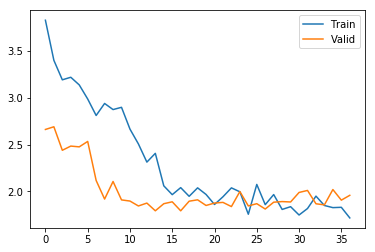

In [36]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train", "Valid"])

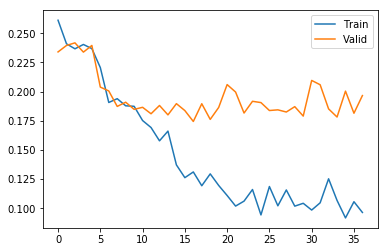

In [37]:
plt.plot(history.history["on_off_loss"])
plt.plot(history.history["val_on_off_loss"])
plt.legend(["Train", "Valid"])

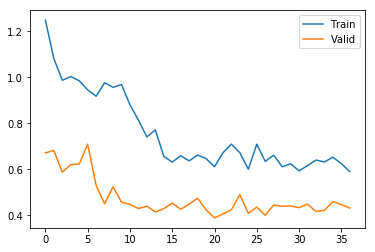

In [38]:
plt.plot(history.history["dyskinesia_loss"])
plt.plot(history.history["val_dyskinesia_loss"])
plt.legend(["Train", "Valid"])

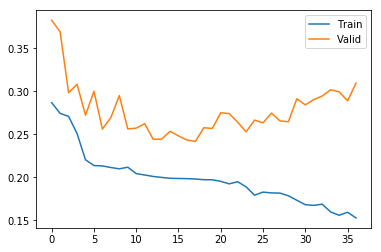

In [39]:
plt.plot(history.history["tremor_loss"])
plt.plot(history.history["val_tremor_loss"])
plt.legend(["Train", "Valid"])

In [42]:

%%bash
squeue -u ms994
scancel 6881629

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           6881629       gpu     bash    ms994  R    8:06:13      1 compute-g-16-255


# Try more data augmentation

In [28]:
#https://github.com/matthew-brett/transforms3d/blob/master/transforms3d/axangles.py
def tfaxangle2mat(x, y, z, angle, is_normalized=False):
#     x, y, z = axis
    if not is_normalized:
        n = tf.math.sqrt(x*x + y*y + z*z)
        x = x/n
        y = y/n
        z = z/n
    c = tf.math.cos(angle); s = tf.math.sin(angle); C = 1-c
    xs = x*s;   ys = y*s;   zs = z*s
    xC = x*C;   yC = y*C;   zC = z*C
    xyC = x*yC; yzC = y*zC; zxC = z*xC
    return tf.reshape(tf.concat([
             x*xC+c,   xyC-zs,   zxC+ys ,
             xyC+zs,   y*yC+c,   yzC-xs ,
             zxC-ys,   yzC+xs,   z*zC+c ], axis=-1), (3,3))

In [18]:
std = 1/16 #allow deviation from real rotation with pi/16 std
def map_example_to_simple_train(example):
    data = example['watch_accel']
    data = tf.reshape(data, (1500,3))
    update_matrix = tfaxangle2mat(tf.constant(0.0), tf.constant(0.0), tf.constant(1.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    update_matrix = update_matrix @ tfaxangle2mat(tf.constant(0.0), tf.constant(1.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    update_matrix = update_matrix @ tfaxangle2mat(tf.constant(1.0), tf.constant(0.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    data = data @ update_matrix
    return data, (example['on_off'][0], example['dyskinesia'][0], example['tremor'][0],)

In [12]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=train_ind, map_func=map_example_to_simple_train)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=valid_ind, map_func=map_example_to_simple)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=test_ind,  map_func=map_example_to_simple)

NameError: name 'map_example_to_simple_train' is not defined

In [20]:
num_cnn_layers = 5
num_lstm_layers = 0
num_lin_layers = 5
dropout = 0.5
lin_h=128
inputLayer = tf.keras.layers.Input((1500, 3))
x = inputLayer
x = tf.keras.layers.GaussianNoise(0.005)(x)


for i in range(num_cnn_layers):
    x = tf.keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
    x = tf.keras.layers.BatchNormalization()(x)

for j in range(num_lstm_layers):
    x = tf.keras.layers.CuDNNLSTM(16, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)



x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = tf.keras.layers.Dense(lin_h)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_on_off = tf.keras.layers.ReLU(name="on_off", max_value=1)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_dyskinesia = tf.keras.layers.ReLU(name="dyskinesia", max_value=2)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_tremor = tf.keras.layers.ReLU(name="tremor", max_value=4)(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])
model.compile(tf.keras.optimizers.Adam(lr=0.001), loss=["mean_squared_error", "mean_squared_error", "mean_squared_error", ], loss_weights=[4,2,1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 1500, 3)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1500, 16)     160         gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
leaky_re_lu_21 (LeakyReLU)      (None, 1500, 16)     0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [ ]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm_realpd.h5", save_best_only=True, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=15)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.5)
history = model.fit(train_data, steps_per_epoch=500, epochs=200, validation_data=valid_data, validation_steps=100, callbacks=[modelCheckpoint, reduceLR, earlyStopping])

Epoch 1/200
499/500 [============================>.] - ETA: 0s - loss: 2.8572 - on_off_loss: 0.2548 - dyskinesia_loss: 0.2827 - tremor_loss: 1.2724
Epoch 00001: val_loss improved from inf to 2.25072, saving model to /n/scratch2/ms994/cnnlstm_realpd.h5
500/500 [==============================] - 342s 684ms/step - loss: 2.8523 - on_off_loss: 0.2543 - dyskinesia_loss: 0.2822 - tremor_loss: 1.2706 - val_loss: 2.2507 - val_on_off_loss: 0.2341 - val_dyskinesia_loss: 0.4375 - val_tremor_loss: 0.4395
Epoch 2/200
499/500 [============================>.] - ETA: 0s - loss: 2.6136 - on_off_loss: 0.2416 - dyskinesia_loss: 0.2728 - tremor_loss: 1.1017
Epoch 00002: val_loss improved from 2.25072 to 2.16376, saving model to /n/scratch2/ms994/cnnlstm_realpd.h5
500/500 [==============================] - 311s 622ms/step - loss: 2.6121 - on_off_loss: 0.2411 - dyskinesia_loss: 0.2739 - tremor_loss: 1.0999 - val_loss: 2.1638 - val_on_off_loss: 0.2396 - val_dyskinesia_loss: 0.4391 - val_tremor_loss: 0.3272
Ep

In [27]:
model = tf.keras.models.load_model("/n/scratch2/ms994/cnnlstm_realpd.h5")

In [29]:
model.evaluate(test_data, steps=1000)

1000/1000 [==============================] - 403s 403ms/step - loss: 3.2436 - on_off_loss: 0.3885 - dyskinesia_loss: 0.7361 - tremor_loss: 0.2173


[3.243612763285637, 0.38854158, 0.7360737, 0.21729973]

# Autoencoder

In [9]:
def map_example_to_data(example):
    std = 1/2
    accel_data = example['watch_accel']
    accel_data = tf.reshape(accel_data, (1500,3))
    gyro_data = example["watch_gyro"]
    gyro_data = tf.reshape(gyro_data, (1500, 3))
    phone_accel_data = example["watch_phone"] #im bad at naming. whoops
    phone_accel_data = tf.reshape(phone_accel_data, (1500, 3))
#     update_matrix = tfaxangle2mat(tf.constant(0.0), tf.constant(0.0), tf.constant(1.0), tf.random.normal((1,)) * tf.constant(3.14*std))
#     update_matrix = update_matrix @ tfaxangle2mat(tf.constant(0.0), tf.constant(1.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
#     update_matrix = update_matrix @ tfaxangle2mat(tf.constant(1.0), tf.constant(0.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
#     accel_data = accel_data @ update_matrix
#     gyro_data = gyro_data @ update_matrix
#     phone_accel_data = phone_accel_data @ update_matrix
    return (accel_data, gyro_data, phone_accel_data), (accel_data[14:1486], gyro_data[14:1486], phone_accel_data[14:1486])
def get_batched_dataset_sing_out(filenames, batch_size, m_ids, map_func=None, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=3, num_parallel_calls=3)

    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
#     dataset = dataset.cache()
    dataset = dataset.filter(lambda example: tf_is_in_set(example["measurement_id"][0], tf.constant(m_ids, dtype=tf.int64)))
    dataset = dataset.map(map_func)
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x[0], 0) > 0.01))
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x[1], 0) > 0.01))
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x[2], 0) > 0.05))

    

    
    dataset = dataset.repeat()
    if is_train:
        dataset = dataset.shuffle(2056)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset
train_data = get_batched_dataset_sing_out("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=train_ind, map_func=map_example_to_data)
valid_data = get_batched_dataset_sing_out("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=valid_ind, map_func=map_example_to_data)
test_data = get_batched_dataset_sing_out("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=test_ind,  map_func=map_example_to_data)

In [10]:
num_cnn_layers = 6
num_lstm_layers = 0
dropout = 0.5
lin_h=128
watch_accel = tf.keras.layers.Input((1500, 3), name="watch_accel_in")
watch_gyro = tf.keras.layers.Input((1500, 3), name="watch_gyro_in")
phone_accel = tf.keras.layers.Input((1500, 3), name="phone_accel_in")
all_inputs = [watch_accel, watch_gyro, phone_accel]
all_cnn_outputs = []

for inputLayer in all_inputs:
    x = inputLayer
    x = tf.keras.layers.GaussianNoise(0.01)(x)


    for i in range(num_cnn_layers):
        x = tf.keras.layers.Conv1D(2**int(i/2)*3, (3,), padding="same")(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool1D((2,))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten()(x)
    all_cnn_outputs.append(x)

x = tf.keras.layers.Concatenate()(all_cnn_outputs)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x_shared = x
all_output_names = ["watch_accel_out", "watch_gyro_out", "phone_accel_out"]
all_outputs = []
for outputLayer in all_output_names:
    x = tf.keras.layers.Dense(276)(x_shared)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Reshape((23,12))(x)
    
    for i in range(num_cnn_layers):
        x = tf.keras.layers.Conv1D(3*2**int((num_cnn_layers-i-1)/2), (3,), padding="same")(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling1D((2))(x)
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(3, (3,), padding="same", name=outputLayer)(x)
    all_outputs.append(x)
model = tf.keras.Model(inputs=all_inputs, outputs=all_outputs)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
watch_accel_in (InputLayer)     (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
watch_gyro_in (InputLayer)      (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
phone_accel_in (InputLayer)     (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 1500, 3)      0           watch_accel_in[0][0]             
_____________________________________

In [11]:
model.compile("adam", "logcosh", metrics=["mean_squared_error"])

In [12]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/real_pd_autoencoder.h5", save_best_only=True, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=15)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.5)
history = model.fit(train_data, steps_per_epoch=500, epochs=200, validation_data=valid_data, validation_steps=100, callbacks=[modelCheckpoint, reduceLR, earlyStopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
499/500 [============================>.] - ETA: 0s - loss: 5.3023 - watch_accel_out_loss: 2.6307 - watch_gyro_out_loss: 0.0997 - phone_accel_out_loss: 2.5718 - watch_accel_out_mean_squared_error: 18.3943 - watch_gyro_out_mean_squared_error: 0.3147 - phone_accel_out_mean_squared_error: 19.0113
Epoch 00001: val_loss improved from inf to 6.52399, saving model to /n/scratch2/ms994/real_pd_autoencoder.h5
500/500 [==============================] - 144s 288ms/step - loss: 5.2980 - watch_accel_out_loss: 2.6277 - watch_gyro_out_loss: 0.0997 - phone_accel_out_loss: 2.5706 - watch_accel_out_mean_squared_error: 18.3681 - watch_gyro_out_mean_squared_error: 0.3148 - phone_accel_out_mean_squared_error: 19.0049 - val_loss: 6.5240 - val_watch_accel_out_loss: 4.2824 - val_watch_gyro_out_loss: 0.0913 - val_phone_accel_out_loss: 2.1502 - val_watch_accel_out_mean_squared_error: 37.3694 - val_watch_gyro_out_mean_squared_error: 0.3106 - val_phone_ac

Epoch 18/200
499/500 [============================>.] - ETA: 0s - loss: 1.1634 - watch_accel_out_loss: 0.5675 - watch_gyro_out_loss: 0.0942 - phone_accel_out_loss: 0.5017 - watch_accel_out_mean_squared_error: 2.4859 - watch_gyro_out_mean_squared_error: 0.2963 - phone_accel_out_mean_squared_error: 2.2206
Epoch 00018: val_loss improved from 0.83131 to 0.82500, saving model to /n/scratch2/ms994/real_pd_autoencoder.h5
500/500 [==============================] - 93s 187ms/step - loss: 1.1635 - watch_accel_out_loss: 0.5675 - watch_gyro_out_loss: 0.0942 - phone_accel_out_loss: 0.5018 - watch_accel_out_mean_squared_error: 2.4857 - watch_gyro_out_mean_squared_error: 0.2963 - phone_accel_out_mean_squared_error: 2.2211 - val_loss: 0.8250 - val_watch_accel_out_loss: 0.4687 - val_watch_gyro_out_loss: 0.0897 - val_phone_accel_out_loss: 0.2666 - val_watch_accel_out_mean_squared_error: 2.1540 - val_watch_gyro_out_mean_squared_error: 0.3034 - val_phone_accel_out_mean_squared_error: 1.1341
Epoch 19/200
4

Epoch 35/200
499/500 [============================>.] - ETA: 0s - loss: 1.1427 - watch_accel_out_loss: 0.5596 - watch_gyro_out_loss: 0.0941 - phone_accel_out_loss: 0.4890 - watch_accel_out_mean_squared_error: 2.4531 - watch_gyro_out_mean_squared_error: 0.2963 - phone_accel_out_mean_squared_error: 2.1760
Epoch 00035: val_loss did not improve from 0.81206
500/500 [==============================] - 92s 184ms/step - loss: 1.1428 - watch_accel_out_loss: 0.5595 - watch_gyro_out_loss: 0.0941 - phone_accel_out_loss: 0.4891 - watch_accel_out_mean_squared_error: 2.4526 - watch_gyro_out_mean_squared_error: 0.2962 - phone_accel_out_mean_squared_error: 2.1760 - val_loss: 0.8153 - val_watch_accel_out_loss: 0.4622 - val_watch_gyro_out_loss: 0.0893 - val_phone_accel_out_loss: 0.2638 - val_watch_accel_out_mean_squared_error: 2.1191 - val_watch_gyro_out_mean_squared_error: 0.3012 - val_phone_accel_out_mean_squared_error: 1.1279
Epoch 36/200
499/500 [============================>.] - ETA: 0s - loss: 1.14

Epoch 44/200
499/500 [============================>.] - ETA: 0s - loss: 1.1487 - watch_accel_out_loss: 0.5610 - watch_gyro_out_loss: 0.0939 - phone_accel_out_loss: 0.4937 - watch_accel_out_mean_squared_error: 2.4576 - watch_gyro_out_mean_squared_error: 0.2958 - phone_accel_out_mean_squared_error: 2.1881
Epoch 00044: val_loss did not improve from 0.81206
500/500 [==============================] - 93s 186ms/step - loss: 1.1488 - watch_accel_out_loss: 0.5611 - watch_gyro_out_loss: 0.0940 - phone_accel_out_loss: 0.4937 - watch_accel_out_mean_squared_error: 2.4582 - watch_gyro_out_mean_squared_error: 0.2959 - phone_accel_out_mean_squared_error: 2.1884 - val_loss: 0.8176 - val_watch_accel_out_loss: 0.4627 - val_watch_gyro_out_loss: 0.0895 - val_phone_accel_out_loss: 0.2654 - val_watch_accel_out_mean_squared_error: 2.1270 - val_watch_gyro_out_mean_squared_error: 0.3024 - val_phone_accel_out_mean_squared_error: 1.1332
Epoch 45/200
499/500 [============================>.] - ETA: 0s - loss: 1.14

In [14]:
pred = model.predict(train_data, steps=1)

In [15]:
import  matplotlib.pyplot as plt

In [17]:
pred[0].shape

(128, 1472, 3)

In [21]:
iterator = train_data.take(1).make_one_shot_iterator()

In [23]:
next(iterator)

TypeError: 'Iterator' object is not an iterator

In [ ]:
plt.plot(train_data[])

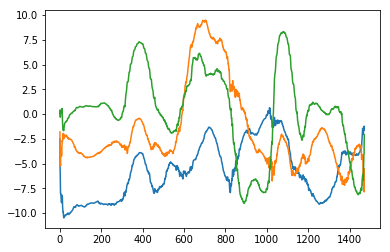

In [18]:
plt.plot(pred[0][0])

In [47]:
from addict import Dict
history = Dict(history.history)

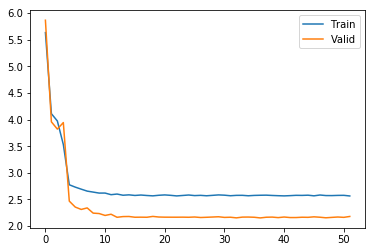

In [51]:
plt.plot(history.loss)
plt.plot(history.val_loss)
plt.legend(["Train", "Valid"])

# Try autoencoder, but don't use filtering at all

In [11]:
#https://github.com/matthew-brett/transforms3d/blob/master/transforms3d/axangles.py
std = 1/16
def tfaxangle2mat(x, y, z, angle, is_normalized=False):
#     x, y, z = axis
    if not is_normalized:
        n = tf.math.sqrt(x*x + y*y + z*z)
        x = x/n
        y = y/n
        z = z/n
    c = tf.math.cos(angle); s = tf.math.sin(angle); C = 1-c
    xs = x*s;   ys = y*s;   zs = z*s
    xC = x*C;   yC = y*C;   zC = z*C
    xyC = x*yC; yzC = y*zC; zxC = z*xC
    return tf.reshape(tf.concat([
             x*xC+c,   xyC-zs,   zxC+ys ,
             xyC+zs,   y*yC+c,   yzC-xs ,
             zxC-ys,   yzC+xs,   z*zC+c ], axis=-1), (3,3))
def map_example_to_data(example):
    accel_data = example['watch_accel']
    accel_data = tf.reshape(accel_data, (1500,3))
    gyro_data = example["watch_gyro"]
    gyro_data = tf.reshape(gyro_data, (1500, 3))
    phone_accel_data = example["watch_phone"] #im bad at naming. whoops
    phone_accel_data = tf.reshape(phone_accel_data, (1500, 3))
    update_matrix = tfaxangle2mat(tf.constant(0.0), tf.constant(0.0), tf.constant(1.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    update_matrix = update_matrix @ tfaxangle2mat(tf.constant(0.0), tf.constant(1.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    update_matrix = update_matrix @ tfaxangle2mat(tf.constant(1.0), tf.constant(0.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    accel_data = accel_data @ update_matrix
    gyro_data = gyro_data @ update_matrix
    phone_accel_data = phone_accel_data @ update_matrix
    return (accel_data, gyro_data, phone_accel_data), (accel_data[14:1486], gyro_data[14:1486], phone_accel_data[14:1486])
def get_batched_dataset_sing_out(filenames, batch_size, map_func=None, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=3, num_parallel_calls=3)

    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
#     dataset = dataset.cache()
    dataset = dataset.map(map_func)
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x[0], 0) > 0.01))
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x[1], 0) > 0.01))
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x[2], 0) > 0.01))

    

    
    dataset = dataset.repeat()
    if is_train:
        dataset = dataset.shuffle(2056)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset
train_data = get_batched_dataset_sing_out("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128,  map_func=map_example_to_data)
# valid_data = get_batched_dataset_sing_out("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=valid_ind, map_func=map_example_to_data)
# test_data = get_batched_dataset_sing_out("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=test_ind,  map_func=map_example_to_data)

In [18]:
num_cnn_layers = 6
num_lstm_layers = 0
dropout = 0.5
lin_h=128
watch_accel = tf.keras.layers.Input((1500, 3), name="watch_accel_in")
watch_gyro = tf.keras.layers.Input((1500, 3), name="watch_gyro_in")
phone_accel = tf.keras.layers.Input((1500, 3), name="phone_accel_in")
all_inputs = [watch_accel, watch_gyro, phone_accel]
all_cnn_outputs = []

for inputLayer in all_inputs:
    x = inputLayer
    x = tf.keras.layers.GaussianNoise(0.01)(x)


    for i in range(num_cnn_layers):
        x = tf.keras.layers.Conv1D(2**int(min(i, 4))*3, (3,), padding="same")(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool1D((2,))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten()(x)
    all_cnn_outputs.append(x)

x = tf.keras.layers.Concatenate()(all_cnn_outputs)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization(name="encoder_out")(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization(name="decoder_in")(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x_shared = x
all_output_names = ["watch_accel_out", "watch_gyro_out", "phone_accel_out"]
all_outputs = []
for outputLayer in all_output_names:
    x = tf.keras.layers.Dense(23*48)(x_shared)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Reshape((23,48))(x)
    
    for i in range(num_cnn_layers):
        x = tf.keras.layers.Conv1D(3*2**int(min(num_cnn_layers-i-1, 4)), (3,), padding="same")(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling1D((2))(x)
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(3, (3,), padding="same", name=outputLayer)(x)
    all_outputs.append(x)
model = tf.keras.Model(inputs=all_inputs, outputs=all_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
watch_accel_in (InputLayer)     (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
watch_gyro_in (InputLayer)      (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
phone_accel_in (InputLayer)     (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
gaussian_noise_12 (GaussianNois (None, 1500, 3)      0           watch_accel_in[0][0]             
__________________________________________________________________________________________________
gaussian_n

In [19]:
model.compile("adam", "logcosh", metrics=["mean_squared_error"])
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/real_pd_v2_autoencoder.h5", monitor="loss", save_best_only=True, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=15)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=1, factor=0.5)
history = model.fit(train_data, steps_per_epoch=200, epochs=1000, callbacks=[modelCheckpoint, reduceLR, earlyStopping])

Epoch 1/1000
199/200 [============================>.] - ETA: 0s - loss: 6.5333 - watch_accel_out_loss: 3.6872 - watch_gyro_out_loss: 0.1119 - phone_accel_out_loss: 2.7342 - watch_accel_out_mean_squared_error: 28.1854 - watch_gyro_out_mean_squared_error: 0.9851 - phone_accel_out_mean_squared_error: 18.9136
Epoch 00001: loss improved from inf to 6.52788, saving model to /n/scratch2/ms994/real_pd_v2_autoencoder.h5
200/200 [==============================] - 182s 911ms/step - loss: 6.5279 - watch_accel_out_loss: 3.6849 - watch_gyro_out_loss: 0.1118 - phone_accel_out_loss: 2.7312 - watch_accel_out_mean_squared_error: 28.1618 - watch_gyro_out_mean_squared_error: 0.9836 - phone_accel_out_mean_squared_error: 18.8828
Epoch 2/1000
199/200 [============================>.] - ETA: 0s - loss: 4.1968 - watch_accel_out_loss: 2.6031 - watch_gyro_out_loss: 0.0888 - phone_accel_out_loss: 1.5049 - watch_accel_out_mean_squared_error: 16.7350 - watch_gyro_out_mean_squared_error: 0.5195 - phone_accel_out_mean

200/200 [==============================] - 32s 158ms/step - loss: 1.6568 - watch_accel_out_loss: 0.9847 - watch_gyro_out_loss: 0.0846 - phone_accel_out_loss: 0.5875 - watch_accel_out_mean_squared_error: 5.2380 - watch_gyro_out_mean_squared_error: 0.2716 - phone_accel_out_mean_squared_error: 2.7191
Epoch 13/1000
199/200 [============================>.] - ETA: 0s - loss: 1.6255 - watch_accel_out_loss: 0.9644 - watch_gyro_out_loss: 0.0839 - phone_accel_out_loss: 0.5772 - watch_accel_out_mean_squared_error: 5.0947 - watch_gyro_out_mean_squared_error: 0.2702 - phone_accel_out_mean_squared_error: 2.6728
Epoch 00013: loss improved from 1.65680 to 1.62628, saving model to /n/scratch2/ms994/real_pd_v2_autoencoder.h5
200/200 [==============================] - 31s 156ms/step - loss: 1.6263 - watch_accel_out_loss: 0.9643 - watch_gyro_out_loss: 0.0839 - phone_accel_out_loss: 0.5781 - watch_accel_out_mean_squared_error: 5.0946 - watch_gyro_out_mean_squared_error: 0.2703 - phone_accel_out_mean_square

Epoch 36/1000
199/200 [============================>.] - ETA: 0s - loss: 1.4005 - watch_accel_out_loss: 0.8446 - watch_gyro_out_loss: 0.0846 - phone_accel_out_loss: 0.4713 - watch_accel_out_mean_squared_error: 4.4375 - watch_gyro_out_mean_squared_error: 0.2718 - phone_accel_out_mean_squared_error: 2.1123
Epoch 00036: loss did not improve from 1.39470
200/200 [==============================] - 30s 149ms/step - loss: 1.3999 - watch_accel_out_loss: 0.8445 - watch_gyro_out_loss: 0.0846 - phone_accel_out_loss: 0.4708 - watch_accel_out_mean_squared_error: 4.4366 - watch_gyro_out_mean_squared_error: 0.2717 - phone_accel_out_mean_squared_error: 2.1108
Epoch 37/1000
199/200 [============================>.] - ETA: 0s - loss: 1.3868 - watch_accel_out_loss: 0.8336 - watch_gyro_out_loss: 0.0837 - phone_accel_out_loss: 0.4696 - watch_accel_out_mean_squared_error: 4.3772 - watch_gyro_out_mean_squared_error: 0.2691 - phone_accel_out_mean_squared_error: 2.0960
Epoch 00037: loss improved from 1.39470 to

In [22]:
from addict import Dict
from matplotlib import pyplot as plt

In [21]:
history = Dict(history.history)

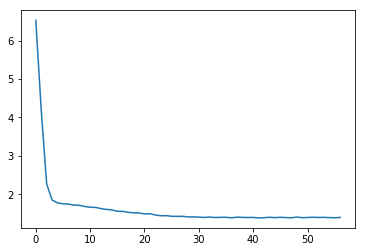

In [26]:
plt.plot(history.loss)
# plt.plot(history.val_loss)
# plt.legend(["Train", "Valid"])

In [61]:
import pickle as pkl
pkl.dump(history.history, open("history.pkl", "wb"))

In [27]:
model = tf.keras.models.load_model("/n/scratch2/ms994/real_pd_v2_autoencoder.h5")

In [58]:
pred = model.predict([[allResults[0][0][:1500]], [allResults[0][1][:1500]], [allResults[0][2][:1500]]])

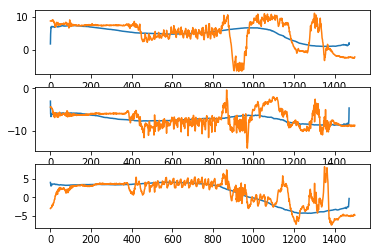

In [70]:
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(pred[0][0][:,i])
    plt.plot(allResults[0][0][:1500][:,i])

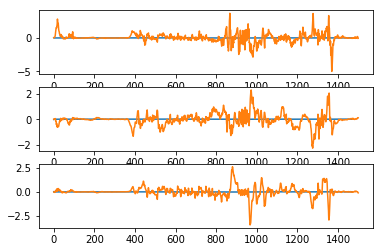

In [67]:
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(pred[1][0][:,i])
    plt.plot(allResults[0][1][:1500][:,i])

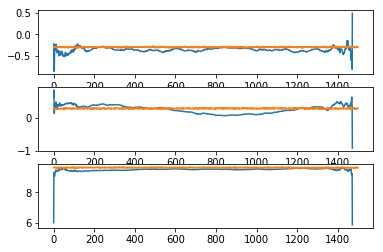

In [68]:
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(pred[2][0][:,i])
    plt.plot(allResults[0][2][:1500][:,i])

In [29]:
iterator = train_data.take(10).make_one_shot_iterator()

In [30]:

allData = []
with tf.Session()
for i in iterator:
    allData.append(i)

TypeError: 'Iterator' object is not iterable

In [45]:
(allData[0][0])

(<tf.Tensor: id=54282, shape=(128, 1500, 3), dtype=float32, numpy=
 array([[[-5.8470235 , -6.0731473 ,  5.3718185 ],
         [-5.795031  , -6.1582437 ,  5.403045  ],
         [-5.8013124 , -6.1278086 ,  5.4345827 ],
         ...,
         [-5.878286  , -6.2066674 ,  5.414472  ],
         [-5.7789106 , -6.189033  ,  5.392529  ],
         [-5.8384585 , -6.178126  ,  5.40722   ]],
 
        [[-1.807893  ,  9.968891  , -2.5022984 ],
         [-1.9121975 , 10.944147  , -1.5841433 ],
         [-2.0292618 , 10.869697  , -1.042809  ],
         ...,
         [ 5.9659944 ,  4.2490225 , -6.6436653 ],
         [ 7.0037003 ,  3.273254  , -3.9365466 ],
         [ 3.4544864 ,  4.3305078 , -6.0681906 ]],
 
        [[ 9.548865  ,  1.4126166 ,  2.134171  ],
         [ 9.584011  ,  1.4559485 ,  2.1683643 ],
         [ 9.519697  ,  1.4591641 ,  2.0602372 ],
         ...,
         [ 9.537253  ,  1.4025645 ,  2.1890209 ],
         [ 9.550177  ,  1.4520484 ,  2.003727  ],
         [ 9.588971  ,  1.4731433 ,

In [54]:
len(((allData[0][0][0]).numpy(), (allData[0][0][1]).numpy(), (allData[0][0][2]).numpy()))

3

In [57]:
pred = model.predict([(allData[0][0][0]).numpy(), (allData[0][0][1]).numpy(), (allData[0][0][2]).numpy()])

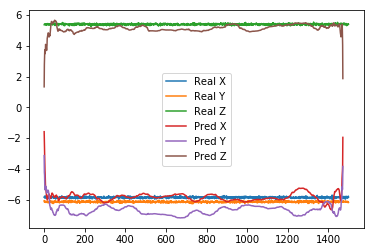

In [68]:
import matplotlib.pyplot as plt
plt.plot((allData[0][0][0]).numpy()[0])
plt.plot(pred[0][0])
plt.legend(["Real X", "Real Y", "Real Z", "Pred X", "Pred Y", "Pred Z"])
plt.show()

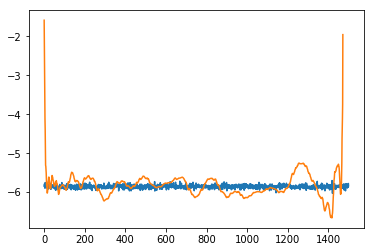

In [71]:
import matplotlib.pyplot as plt
plt.plot((allData[0][0][0]).numpy()[0][:,0])
plt.plot(pred[0][0][:,0])
plt.show()

# Try to increase dimensionality of encoder output
Clearly, not able to learn key features well i.e. variability.

In [104]:
num_cnn_layers = 4
num_lstm_layers = 0
dropout = 0.5
lin_h=128
watch_accel = tf.keras.layers.Input((1500, 3), name="watch_accel_in")
watch_gyro = tf.keras.layers.Input((1500, 3), name="watch_gyro_in")
phone_accel = tf.keras.layers.Input((1500, 3), name="phone_accel_in")
all_inputs = [watch_accel, watch_gyro, phone_accel]
all_cnn_outputs = []

for inputLayer in all_inputs:
    x = inputLayer
    x = tf.keras.layers.GaussianNoise(0.001)(x)


    for i in range(num_cnn_layers):
        x = tf.keras.layers.Conv1D(2**int(min(i, 3))*3, (3,), padding="same")(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPool1D((2,))(x)
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    all_cnn_outputs.append(x)

x = tf.keras.layers.Concatenate()(all_cnn_outputs)
x = tf.keras.layers.Dense(4096)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(2048)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(4096)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x_shared = x
all_output_names = ["watch_accel_out", "watch_gyro_out", "phone_accel_out"]
all_outputs = []
for outputLayer in all_output_names:
    x = tf.keras.layers.Dense(93*12)(x_shared)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Reshape((93,12))(x)
    for i in range(num_cnn_layers):
        x = tf.keras.layers.Conv1D(3*2**int(min(num_cnn_layers-i-1, 3)), (3,), padding="same")(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.UpSampling1D((2))(x)
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(3, (3,), padding="same", name=outputLayer)(x)
    all_outputs.append(x)
model = tf.keras.Model(inputs=all_inputs, outputs=all_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
watch_accel_in (InputLayer)     (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
watch_gyro_in (InputLayer)      (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
phone_accel_in (InputLayer)     (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
gaussian_noise_51 (GaussianNois (None, 1500, 3)      0           watch_accel_in[0][0]             
__________________________________________________________________________________________________
gaussian_n

In [105]:
#https://github.com/matthew-brett/transforms3d/blob/master/transforms3d/axangles.py
std = 1/16
def tfaxangle2mat(x, y, z, angle, is_normalized=False):
#     x, y, z = axis
    if not is_normalized:
        n = tf.math.sqrt(x*x + y*y + z*z)
        x = x/n
        y = y/n
        z = z/n
    c = tf.math.cos(angle); s = tf.math.sin(angle); C = 1-c
    xs = x*s;   ys = y*s;   zs = z*s
    xC = x*C;   yC = y*C;   zC = z*C
    xyC = x*yC; yzC = y*zC; zxC = z*xC
    return tf.reshape(tf.concat([
             x*xC+c,   xyC-zs,   zxC+ys ,
             xyC+zs,   y*yC+c,   yzC-xs ,
             zxC-ys,   yzC+xs,   z*zC+c ], axis=-1), (3,3))
def map_example_to_data(example):
    accel_data = example['watch_accel']
    accel_data = tf.reshape(accel_data, (1500,3))
    gyro_data = example["watch_gyro"]
    gyro_data = tf.reshape(gyro_data, (1500, 3))
    phone_accel_data = example["watch_phone"] #im bad at naming. whoops
    phone_accel_data = tf.reshape(phone_accel_data, (1500, 3))
    update_matrix = tfaxangle2mat(tf.constant(0.0), tf.constant(0.0), tf.constant(1.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    update_matrix = update_matrix @ tfaxangle2mat(tf.constant(0.0), tf.constant(1.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    update_matrix = update_matrix @ tfaxangle2mat(tf.constant(1.0), tf.constant(0.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    accel_data = accel_data @ update_matrix
    gyro_data = gyro_data @ update_matrix
    phone_accel_data = phone_accel_data @ update_matrix
    return (accel_data, gyro_data, phone_accel_data), (accel_data[6:1494], gyro_data[6:1494], phone_accel_data[6:1494])
def get_batched_dataset_sing_out(filenames, batch_size, map_func=None, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=3, num_parallel_calls=3)

    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
#     dataset = dataset.cache()
    dataset = dataset.map(map_func)
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x[0], 0) > 0.01))
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x[1], 0) > 0.01))
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x[2], 0) > 0.01))

    

    
    dataset = dataset.repeat()
    if is_train:
        dataset = dataset.shuffle(2056)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset
train_data = get_batched_dataset_sing_out("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128,  map_func=map_example_to_data)
# valid_data = get_batched_dataset_sing_out("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=valid_ind, map_func=map_example_to_data)
# test_data = get_batched_dataset_sing_out("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=test_ind,  map_func=map_example_to_data)

In [106]:
model.compile("adam", "logcosh", metrics=["mean_squared_error"])
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/real_pd_v3_autoencoder.h5", monitor="loss", save_best_only=True, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=15)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=1, factor=0.5)
history = model.fit(train_data, steps_per_epoch=200, epochs=1000, callbacks=[modelCheckpoint, reduceLR, earlyStopping])

Epoch 1/1000
199/200 [============================>.] - ETA: 0s - loss: 6.8723 - watch_accel_out_loss: 3.5983 - watch_gyro_out_loss: 0.1067 - phone_accel_out_loss: 3.1673 - watch_accel_out_mean_squared_error: 27.2162 - watch_gyro_out_mean_squared_error: 0.3841 - phone_accel_out_mean_squared_error: 22.9447
Epoch 00001: loss improved from inf to 6.86683, saving model to /n/scratch2/ms994/real_pd_v3_autoencoder.h5
200/200 [==============================] - 546s 3s/step - loss: 6.8668 - watch_accel_out_loss: 3.5953 - watch_gyro_out_loss: 0.1066 - phone_accel_out_loss: 3.1649 - watch_accel_out_mean_squared_error: 27.1898 - watch_gyro_out_mean_squared_error: 0.3837 - phone_accel_out_mean_squared_error: 22.9209
Epoch 2/1000
199/200 [============================>.] - ETA: 0s - loss: 4.5746 - watch_accel_out_loss: 2.3871 - watch_gyro_out_loss: 0.0848 - phone_accel_out_loss: 2.1027 - watch_accel_out_mean_squared_error: 15.9826 - watch_gyro_out_mean_squared_error: 0.2707 - phone_accel_out_mean_sq

200/200 [==============================] - 32s 162ms/step - loss: 1.3994 - watch_accel_out_loss: 0.8149 - watch_gyro_out_loss: 0.0845 - phone_accel_out_loss: 0.5000 - watch_accel_out_mean_squared_error: 4.0752 - watch_gyro_out_mean_squared_error: 0.2714 - phone_accel_out_mean_squared_error: 2.1897
Epoch 13/1000
199/200 [============================>.] - ETA: 0s - loss: 1.3826 - watch_accel_out_loss: 0.8007 - watch_gyro_out_loss: 0.0840 - phone_accel_out_loss: 0.4978 - watch_accel_out_mean_squared_error: 3.9852 - watch_gyro_out_mean_squared_error: 0.2704 - phone_accel_out_mean_squared_error: 2.1757
Epoch 00013: loss improved from 1.39944 to 1.38282, saving model to /n/scratch2/ms994/real_pd_v3_autoencoder.h5
200/200 [==============================] - 33s 167ms/step - loss: 1.3828 - watch_accel_out_loss: 0.8007 - watch_gyro_out_loss: 0.0840 - phone_accel_out_loss: 0.4982 - watch_accel_out_mean_squared_error: 3.9850 - watch_gyro_out_mean_squared_error: 0.2703 - phone_accel_out_mean_square

199/200 [============================>.] - ETA: 0s - loss: 1.2089 - watch_accel_out_loss: 0.6804 - watch_gyro_out_loss: 0.0840 - phone_accel_out_loss: 0.4446 - watch_accel_out_mean_squared_error: 3.2351 - watch_gyro_out_mean_squared_error: 0.2707 - phone_accel_out_mean_squared_error: 1.8798
Epoch 00024: loss improved from 1.22800 to 1.20835, saving model to /n/scratch2/ms994/real_pd_v3_autoencoder.h5
200/200 [==============================] - 32s 162ms/step - loss: 1.2083 - watch_accel_out_loss: 0.6803 - watch_gyro_out_loss: 0.0839 - phone_accel_out_loss: 0.4442 - watch_accel_out_mean_squared_error: 3.2346 - watch_gyro_out_mean_squared_error: 0.2704 - phone_accel_out_mean_squared_error: 1.8784
Epoch 25/1000
199/200 [============================>.] - ETA: 0s - loss: 1.2046 - watch_accel_out_loss: 0.6819 - watch_gyro_out_loss: 0.0847 - phone_accel_out_loss: 0.4379 - watch_accel_out_mean_squared_error: 3.2345 - watch_gyro_out_mean_squared_error: 0.2724 - phone_accel_out_mean_squared_error

Epoch 36/1000
199/200 [============================>.] - ETA: 0s - loss: 1.1300 - watch_accel_out_loss: 0.6243 - watch_gyro_out_loss: 0.0843 - phone_accel_out_loss: 0.4214 - watch_accel_out_mean_squared_error: 2.9237 - watch_gyro_out_mean_squared_error: 0.2704 - phone_accel_out_mean_squared_error: 1.7955
Epoch 00036: loss did not improve from 1.12482
200/200 [==============================] - 30s 149ms/step - loss: 1.1294 - watch_accel_out_loss: 0.6241 - watch_gyro_out_loss: 0.0843 - phone_accel_out_loss: 0.4210 - watch_accel_out_mean_squared_error: 2.9228 - watch_gyro_out_mean_squared_error: 0.2704 - phone_accel_out_mean_squared_error: 1.7944
Epoch 37/1000
199/200 [============================>.] - ETA: 0s - loss: 1.1205 - watch_accel_out_loss: 0.6152 - watch_gyro_out_loss: 0.0834 - phone_accel_out_loss: 0.4219 - watch_accel_out_mean_squared_error: 2.8870 - watch_gyro_out_mean_squared_error: 0.2680 - phone_accel_out_mean_squared_error: 1.7883
Epoch 00037: loss improved from 1.12482 to

Epoch 61/1000
199/200 [============================>.] - ETA: 0s - loss: 1.1134 - watch_accel_out_loss: 0.6138 - watch_gyro_out_loss: 0.0835 - phone_accel_out_loss: 0.4161 - watch_accel_out_mean_squared_error: 2.8796 - watch_gyro_out_mean_squared_error: 0.2686 - phone_accel_out_mean_squared_error: 1.7730
Epoch 00061: loss did not improve from 1.11119
200/200 [==============================] - 29s 147ms/step - loss: 1.1137 - watch_accel_out_loss: 0.6137 - watch_gyro_out_loss: 0.0835 - phone_accel_out_loss: 0.4164 - watch_accel_out_mean_squared_error: 2.8796 - watch_gyro_out_mean_squared_error: 0.2686 - phone_accel_out_mean_squared_error: 1.7738
Epoch 62/1000
199/200 [============================>.] - ETA: 0s - loss: 1.1265 - watch_accel_out_loss: 0.6220 - watch_gyro_out_loss: 0.0843 - phone_accel_out_loss: 0.4203 - watch_accel_out_mean_squared_error: 2.9166 - watch_gyro_out_mean_squared_error: 0.2711 - phone_accel_out_mean_squared_error: 1.7862
Epoch 00062: loss did not improve from 1.1

In [107]:
%%bash
scancel 7274278

In [84]:
pred = model.predict([[allResults[0][0][:1500]], [allResults[0][1][:1500]], [allResults[0][2][:1500]]])

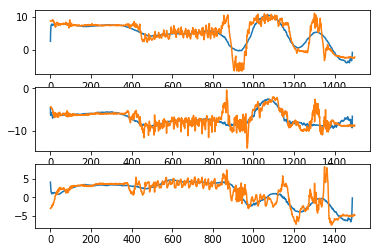

In [85]:
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(pred[0][0][:,i])
    plt.plot(allResults[0][0][:1500][:,i])

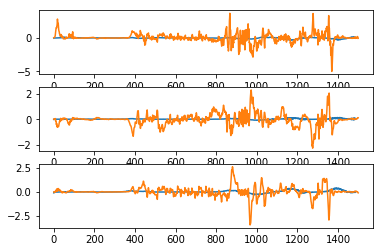

In [86]:
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(pred[1][0][:,i])
    plt.plot(allResults[0][1][:1500][:,i])

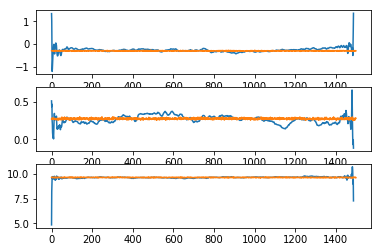

In [87]:
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(pred[2][0][:,i])
    plt.plot(allResults[0][2][:1500][:,i])

# Signal isn't learning frequency components. Let's try autoencoder with FFT

In [11]:
#https://github.com/matthew-brett/transforms3d/blob/master/transforms3d/axangles.py
std = 1/16
def tfaxangle2mat(x, y, z, angle, is_normalized=False):
#     x, y, z = axis
    if not is_normalized:
        n = tf.math.sqrt(x*x + y*y + z*z)
        x = x/n
        y = y/n
        z = z/n
    c = tf.math.cos(angle); s = tf.math.sin(angle); C = 1-c
    xs = x*s;   ys = y*s;   zs = z*s
    xC = x*C;   yC = y*C;   zC = z*C
    xyC = x*yC; yzC = y*zC; zxC = z*xC
    return tf.reshape(tf.concat([
             x*xC+c,   xyC-zs,   zxC+ys ,
             xyC+zs,   y*yC+c,   yzC-xs ,
             zxC-ys,   yzC+xs,   z*zC+c ], axis=-1), (3,3))
def map_example_to_data(example):
    accel_data = example['watch_accel']
    accel_data = tf.reshape(accel_data, (1500,3))
    gyro_data = example["watch_gyro"]
    gyro_data = tf.reshape(gyro_data, (1500, 3))
    phone_accel_data = example["watch_phone"] #im bad at naming. whoops
    phone_accel_data = tf.reshape(phone_accel_data, (1500, 3))
    update_matrix = tfaxangle2mat(tf.constant(0.0), tf.constant(0.0), tf.constant(1.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    update_matrix = update_matrix @ tfaxangle2mat(tf.constant(0.0), tf.constant(1.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    update_matrix = update_matrix @ tfaxangle2mat(tf.constant(1.0), tf.constant(0.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    accel_data = accel_data @ update_matrix
    gyro_data = gyro_data @ update_matrix
    phone_accel_data = phone_accel_data @ update_matrix
    accel_fft = tf.log(tf.transpose(tf.cast(tf.signal.fft(tf.transpose(tf.cast(accel_data, tf.complex64))), tf.float32)))
    gyro_fft = tf.log(tf.transpose(tf.cast(tf.signal.fft(tf.transpose(tf.cast(gyro_data, tf.complex64))), tf.float32)))
    phone_accel_fft = tf.log(tf.transpose(tf.cast(tf.signal.fft(tf.transpose(tf.cast(phone_accel_data, tf.complex64))), tf.float32)))
    return (accel_fft, gyro_fft, phone_accel_fft), (accel_fft, gyro_fft, phone_accel_fft)
def get_batched_dataset_sing_out(filenames, batch_size, map_func=None, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=3, num_parallel_calls=3)

    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
#     dataset = dataset.cache()
    dataset = dataset.map(map_func)
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x[0], 0) > 0.01))
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x[1], 0) > 0.01))
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x[2], 0) > 0.01))

    

    
    dataset = dataset.repeat()
    if is_train:
        dataset = dataset.shuffle(2056)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset
train_data = get_batched_dataset_sing_out("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128,  map_func=map_example_to_data)
# valid_data = get_batched_dataset_sing_out("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=valid_ind, map_func=map_example_to_data)
# test_data = get_batched_dataset_sing_out("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=test_ind,  map_func=map_example_to_data)

In [12]:
train_data

<DatasetV1Adapter shapes: (((128, 1500, 3), (128, 1500, 3), (128, 1500, 3)), ((128, 1500, 3), (128, 1500, 3), (128, 1500, 3))), types: ((tf.float32, tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32))>

In [15]:
num_cnn_layers = 4
num_lstm_layers = 0
dropout = 0.5
lin_h=128
watch_accel = tf.keras.layers.Input((1500, 3), name="watch_accel_in")
watch_gyro = tf.keras.layers.Input((1500, 3), name="watch_gyro_in")
phone_accel = tf.keras.layers.Input((1500, 3), name="phone_accel_in")
all_inputs = [watch_accel, watch_gyro, phone_accel]
all_encoder_out = []

for inputLayer in all_inputs:
    x = inputLayer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(750)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(500)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)

   

    x = tf.keras.layers.Flatten()(x)
    all_encoder_out.append(x)

x = tf.keras.layers.Concatenate()(all_encoder_out)
x = tf.keras.layers.Dense(1000)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1000)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x_shared = x
all_output_names = ["watch_accel_out", "watch_gyro_out", "phone_accel_out"]
all_outputs = []
for outputLayer in all_output_names:
    x = tf.keras.layers.Flatten()(x_shared)
    x = tf.keras.layers.Dense(500)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(750)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(4500)(x)
    x = tf.keras.layers.Reshape((1500,3), name=outputLayer)(x)
    all_outputs.append(x)
model = tf.keras.Model(inputs=all_inputs, outputs=all_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
watch_accel_in (InputLayer)     (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
watch_gyro_in (InputLayer)      (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
phone_accel_in (InputLayer)     (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
flatten_18 (Flatten)            (None, 4500)         0           watch_accel_in[0][0]             
__________________________________________________________________________________________________
flatten_20

In [16]:
model.compile("adam", "logcosh", metrics=["mean_squared_error"])
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/real_pd_fft_autoencoder.h5", monitor="loss", save_best_only=True, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=15)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=1, factor=0.5)
history = model.fit(train_data, steps_per_epoch=200, epochs=1000, callbacks=[modelCheckpoint, reduceLR, earlyStopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000


IndexError: list index out of range